In [87]:
# Für Imports (:P)
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import numpy as np

In [61]:
%matplotlib inline

## Overview of the steps

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Lane detection
1. Lane curvature calculation
1. Inverse perspective transform
1. Display of detected lane on the original image

## 1. Camera calibration

### 1.a Look at files for camera calibration

In [203]:
# Return the list of calibration files
def calibration_files():
    return list(map(lambda x: 'camera_cal/' + x, os.listdir('./camera_cal')))

In [104]:
for file in calibration_files():
    print(file)

camera_cal/calibration1.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration4.jpg
camera_cal/calibration5.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg


In [105]:
print(len(calibration_files()))

20


We have about 20 images for calliberation

In [202]:
# Given a list of image paths, return the loaded images in RGB
# format as a list
def load_images(images):
    loaded_images = []
    
    for image in images:
        loaded_images.append(mpimg.imread(image))
        
    return loaded_images

In [367]:
# Given a list of images and number of images per row,
# display those images
def show_images(images, n_rows, cmaps=[]):
    n_images = len(images)
    n_cols = math.ceil(1.0 * n_images / n_rows)
    
    f, subplots = plt.subplots(n_rows, n_cols, figsize=(20, 9))
    f.tight_layout()
    subplots = subplots.flatten()
    
    for index, image in enumerate(images):
        try:
            cmap = cmaps[index]
        except IndexError:
            cmap = None
            
        subplots[index].imshow(image, cmap=cmap)

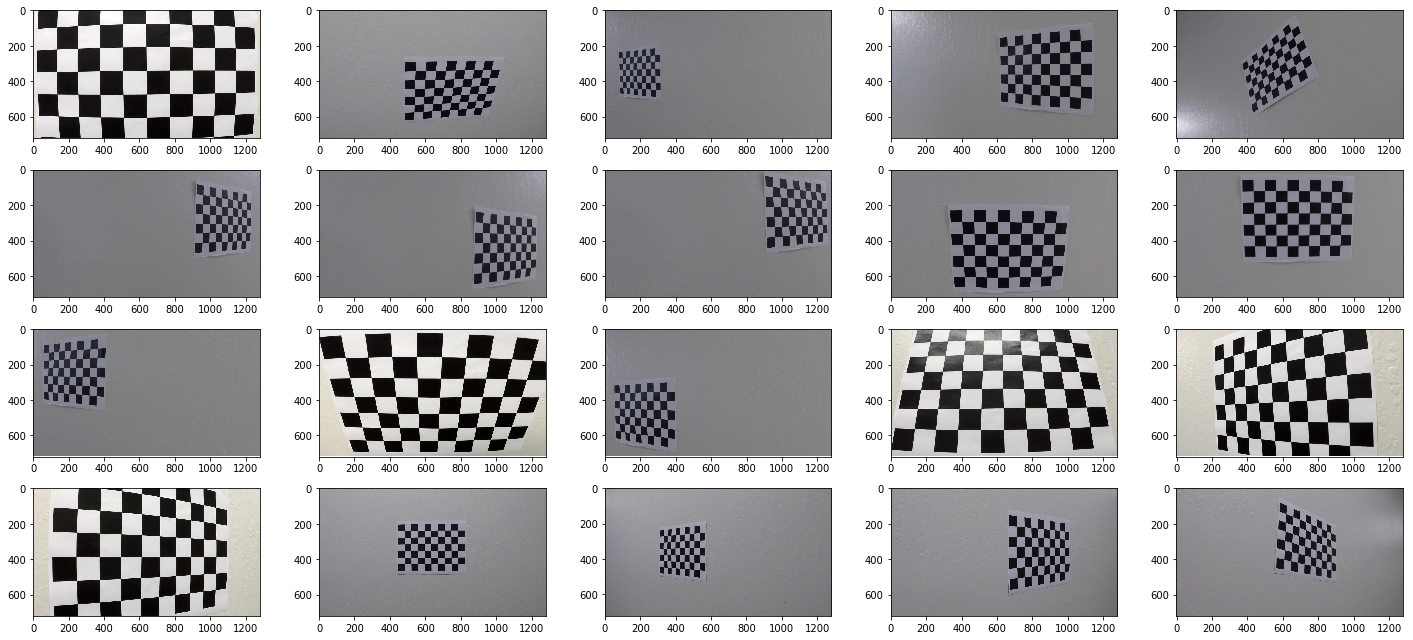

In [106]:
show_images(load_images(calibration_files()), 4)

#### Observation

We can see a bunch of chessboard images from different angles and thus distorted to different extent.

### 1.b Calibrate camera

In [200]:
# Given a list of chessboard images, calculate generate the obj points,
# calculate the imgpoints, and return the distortion parameters
def calibrate_camera(images):
    objpoints = []
    imgpoints = []
    
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        if ret:
            objp = np.zeros((9*6, 3), np.float32)
            objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
            
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, images[0].shape[0:2], None, None)
    
    return mtx, dist

## 2. Distortion correction

In [114]:
mtx, dst = calibrate_camera(load_images(calibration_files()))

In [199]:
# Undistort images given an image, and the distortion
# parameters
def undistort_image(image, mtx, dst):
    return cv2.undistort(image, mtx, dst, None, mtx)

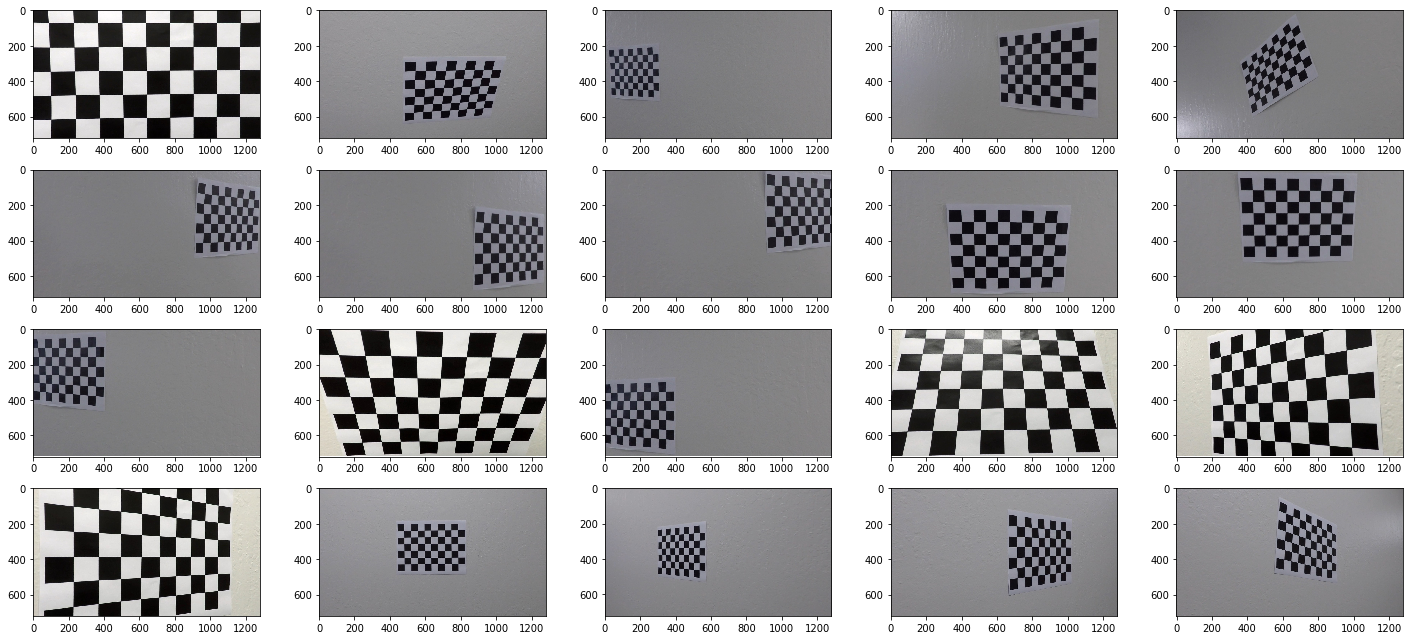

In [124]:
show_images(list(map(lambda x: undistort_image(x, mtx, dst), load_images(calibration_files()))), 4)

#### Observation

Images look pretty undistorted!

## 3. Color/gradient threshold

In [197]:
# Convert an RGB image to grayscale
def grayscale_img(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [198]:
# Display a binary image
def display_binary(img):
    plt.imshow(img, cmap='gray')

### 3.a Sobel gradient

In [196]:
# Apply the x-sobel gradient to the given grayscale
# image
def sobel_x(g_img, thresh=(20, 100)):
    sobel = cv2.Sobel(g_img, cv2.CV_64F, 1, 0)
    abs_sobel = np.abs(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_sobel

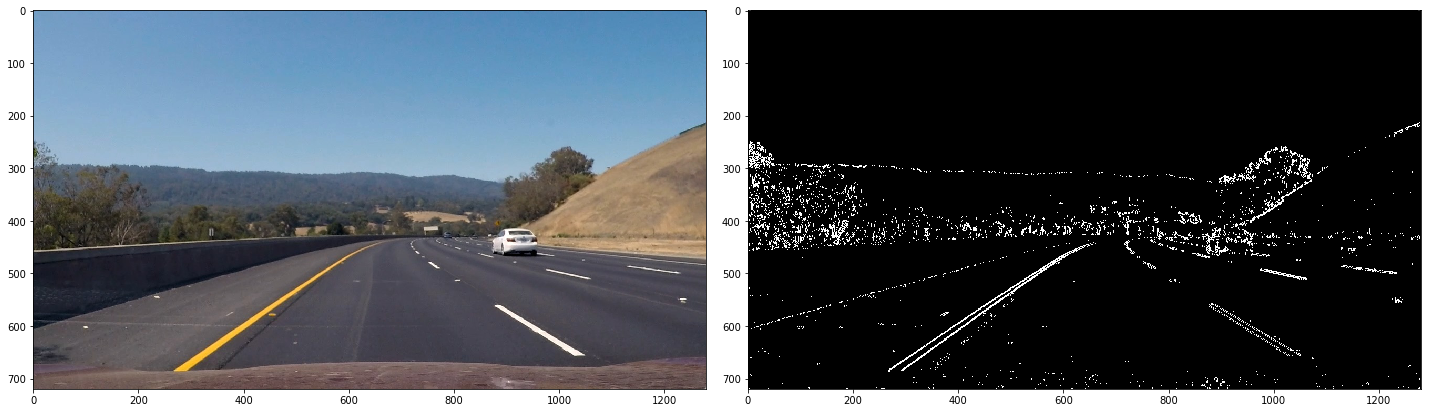

In [546]:
def test_sobel_x():
    img = load_images(['./test_images/test3.jpg'])[0]
    gray = grayscale_img(img)
    sobel = sobel_x(gray, thresh=(20, 100))
    
    show_images([img, sobel], 1, cmaps=[None, 'gray'])
    
test_sobel_x()

#### Observation

Looks pretty decent. Both the lanes have been detected to the extent possible.

### 3.b Color thresholding

In [194]:
# Convert an RGB image to HLS
def hls_img(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [195]:
# Apply color threshold on the S channel to an HLS
# image
def color_threshold(hls, thresh=(170,255)):
    s_channel = hls[:,:,2]
    binary_img = np.zeros_like(s_channel)
    
    binary_img[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_img

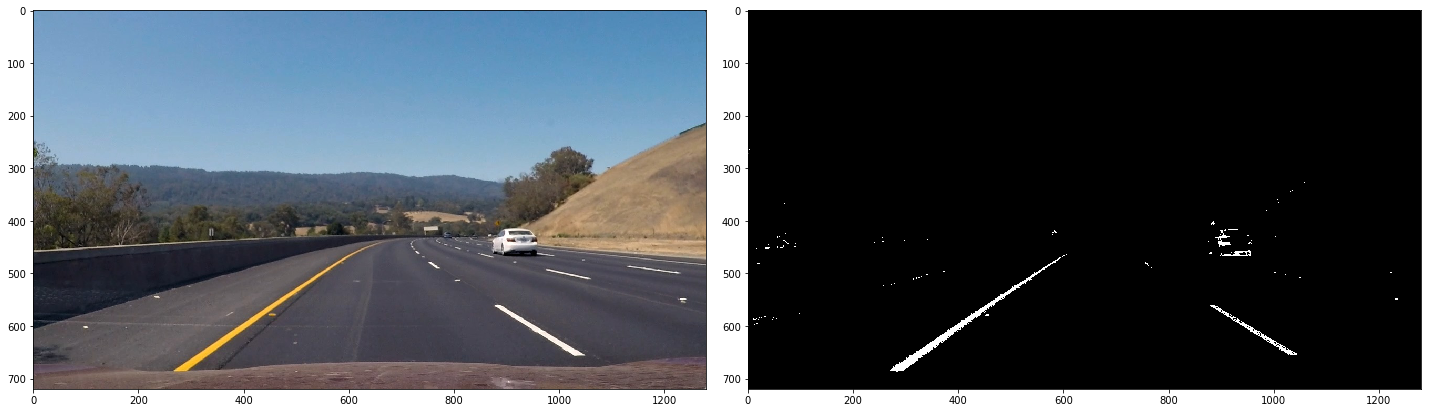

In [547]:
def test_color_threshold():
    img = load_images(['./test_images/test3.jpg'])[0]
    hls = hls_img(img)
    thresholded = color_threshold(hls, thresh=(140, 255))
    
    show_images([img, thresholded], 1, cmaps=[None, 'gray'])

test_color_threshold()

#### Observation

The left lane is crisply detected. The right lane too, to a good extent.

### 3.c Combined thresholding

In [193]:
# Given a variable number of binary images,
# OR them into a combined image
def combine_thresholds(*thresholds):
    # Initialize a binary image
    binary_img = np.zeros_like(thresholds[0])

    for img in thresholds:
        binary_img = binary_img | img
        
    return binary_img

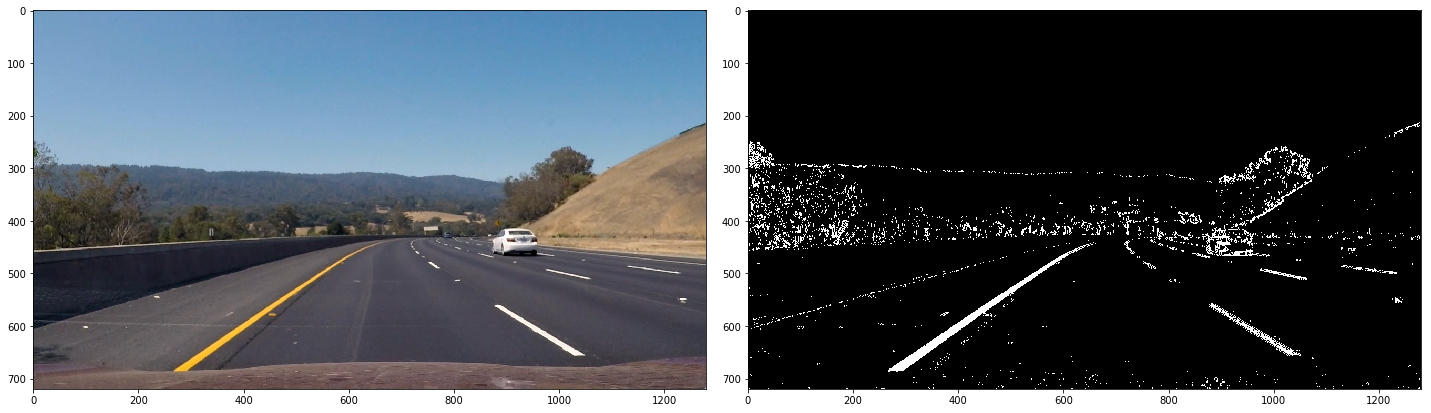

In [548]:
def test_thresholding():
    img = load_images(['./test_images/test3.jpg'])[0]
    g_img = grayscale_img(img)
    hls = hls_img(img)
    
    thresholds = [
        sobel_x(g_img, thresh=(20, 100)),
        color_threshold(hls, thresh=(140, 255))
    ]
    
    final_img = combine_thresholds(*thresholds)
    
    show_images([img, final_img], 1, cmaps=[None, 'gray'])

test_thresholding()

#### Observation

Combining both the thresholding yeilds an image with prominent lanes.

## 4. Perspective transform

### 4.a Find out perspective points

In [304]:
# Given an image, overlay polygon described by points
# on top of it
def draw_polygon(img, points):
    copy = img.copy()
    cv2.polylines(copy, [points], True, (255, 0, 0), thickness=3)
    
    return copy

In [352]:
# Before points for the perspective transform
def perspective_before_points():
    return {
        'bottom-left': (200, 720),
        'bottom-right': (1110, 720),
        'top-left': (560, 470),
        'top-right': (720, 470)
    }

In [300]:
# After points for the perspective transform
def perspective_after_points():
    return {
        'bottom-left': (350, 720),
        'bottom-right': (980, 720),
        'top-left': (350, 0),
        'top-right': (980, 0)
    }

In [305]:
# Given the dictionary of points, convert them to a 
# integer numpy array
def points_to_array(points):
    return np.int32([
        points['top-left'],
        points['top-right'],
        points['bottom-right'],
        points['bottom-left']
    ])

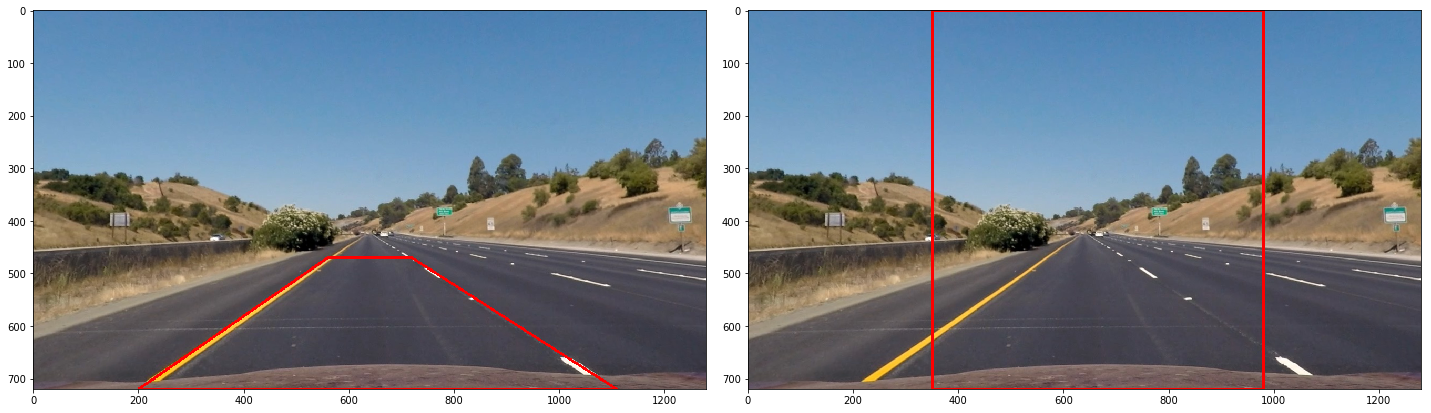

In [353]:
# Test out the points selected above on an image
def test_perspective_points():
    before_points = points_to_array(perspective_before_points())
    after_points = points_to_array(perspective_after_points())
    
    img = load_images(['./test_images/straight_lines1.jpg'])[0]
    img = undistort_image(img, mtx, dst)
    
    img_before = draw_polygon(img, before_points)
    img_after = draw_polygon(img, after_points)
    
    show_images([img_before, img_after], 1)
    
test_perspective_points()

#### Observation

Using the visualization above, it was easy to fiddle with the numbers till I got a satisfactory looking polygon.

### 4.b Use perspective transform on an image

In [311]:
# Given the before and after points, come up with the perspective
# transform matrix "M"
def perspective_transform(before_points, after_points):
    # Convert dictionaries to np arrays
    before_points_np = np.float32(points_to_array(before_points))
    after_points_np = np.float32(points_to_array(after_points))
    
    return cv2.getPerspectiveTransform(before_points_np, after_points_np)

In [308]:
# Given an image and the perspective transform matrix, get the warped
# image
def warp_perspective(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

In [309]:
# A helper function to get M
def std_perspective_transform():
    before_points = perspective_before_points()
    after_points = perspective_after_points()
    
    return perspective_transform(before_points, after_points)

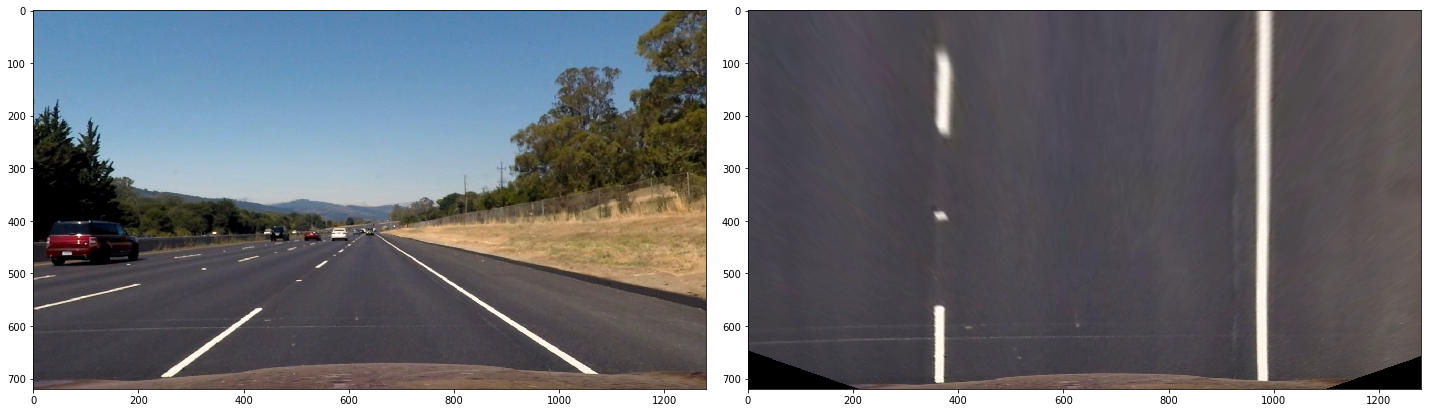

In [358]:
# Check how things are looking
def test_perspective_transform():
    img = load_images(['./test_images/straight_lines2.jpg'])[0]
    img = undistort_image(img, mtx, dst)
    
    M = std_perspective_transform()
    warped_img = warp_perspective(img, M)
    
    show_images([img, warped_img], 1)
    
test_perspective_transform()

#### Observation

The transform looks okay. I have to keep in mind that it's not being applied to the undistorted image above (though in the final pipeline, it will be). The one "trick" that I learnt was the that the values at the top of the image (where the lanes seem to converge) are **highly sensitive.** A single pixel change over there can change the output by a lot. And it makes sense too, since the points at the top are close to each other.

## 5. Lane detection

Let's get down the detecting the two lanes as lines.

### 5.a Get an image ready for lane detection

In [363]:
# Return an image that's ready for lane detection
def image_for_lane_detection(img, mtx, dst):
    # Undistort
    img = undistort_image(img, mtx, dst)
    
    # Grayscale and hls
    g_img = grayscale_img(img)
    hls = hls_img(img)
    
    # Thresholding
    thresholds = [
        sobel_x(g_img, thresh=(20, 100)),
        color_threshold(hls, thresh=(140, 255))
    ]
    thresholded_img = combine_thresholds(*thresholds)
    
    # Perspective transform
    M = std_perspective_transform()
    
    return warp_perspective(thresholded_img, M)

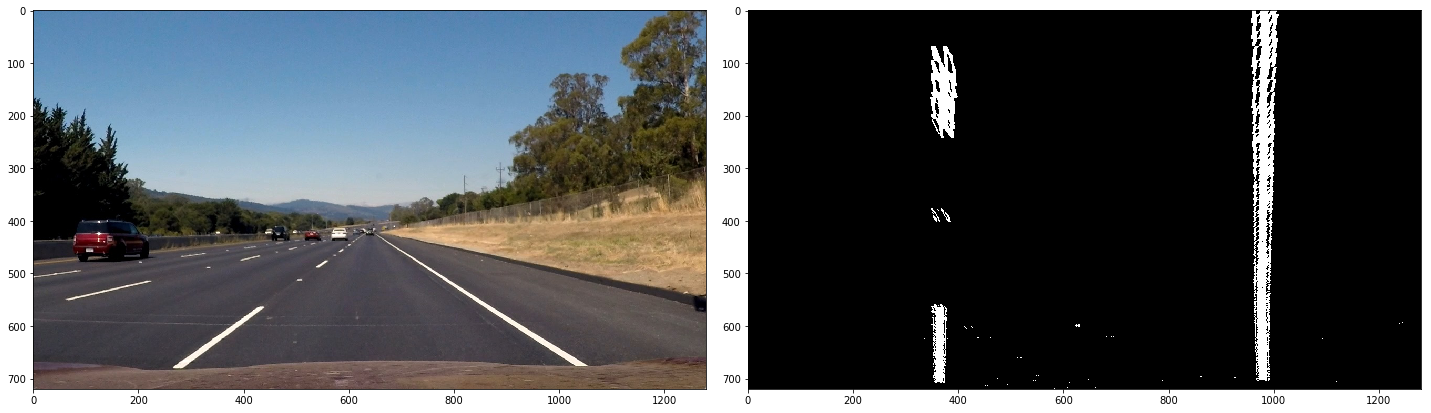

In [371]:
def test_image_for_lane_detection():
    img = load_images(['./test_images/straight_lines2.jpg'])[0]
    
    final_img = image_for_lane_detection(img, mtx, dst)
    
    show_images([img, final_img], 1, cmaps=[None, 'gray'])
    
test_image_for_lane_detection()

#### Observation

The image on the right looks good. We can start lane detection on it.

### 5.b Find lane bases in the histogram

In [482]:
def binary_to_rgb(binary_img):
    img = binary_img * 255
    
    return np.stack([img, img, img], axis=2)

In [480]:
def lanes_starting_image(img_name='straight_lines2.jpg'):
    img = load_images(['./test_images/' + img_name])[0]
    return image_for_lane_detection(img, mtx, dst)

In [375]:
def histogram(binary_img):
    return np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)

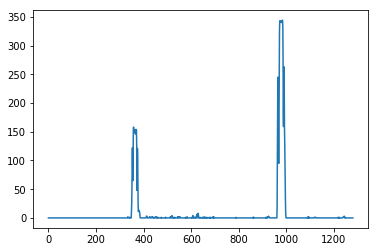

In [378]:
plt.plot(histogram(lanes_starting_image()))

#### Observation

We see two prominent spikes indicating the lanes.

In [379]:
# Get the left and right lane bases
def get_lane_bases(histogram_img):
    midpoint = histogram_img.shape[0]//2
    left_base = np.argmax(histogram_img[:midpoint])
    right_base = np.argmax(histogram_img[midpoint:]) + midpoint
    
    return left_base, right_base

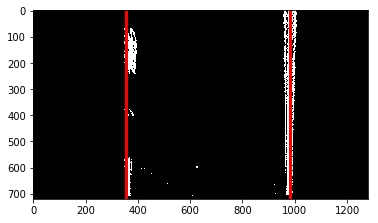

In [462]:
def test_get_lane_bases():
    binary_img = lanes_starting_image()
    img = binary_to_rgb(binary_img)
    
    histogram_img = histogram(binary_img)
    height = binary_img.shape[0]
    left_base, right_base = get_lane_bases(histogram_img)
    
    cv2.line(img, (left_base, 0), (left_base, height), (255,0,0), 10)
    cv2.line(img, (right_base, 0), (right_base, height), (255,0,0), 10)
    plt.imshow(img)
    
test_get_lane_bases()

#### Observation

I've put vertical lines marking the base. They closely match the actual lanes. (This visualization would only work for straight lanes).

### 5.c Find lane boxes

In [505]:
# Get all non-zero pixels
def get_non_zero_pixels(binary_img):
    nonzero = binary_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    return nonzerox, nonzeroy

In [515]:
# n_windows: no. of vertical windows
# minpix: min. number of pixels inside a window
# margin: +- width of the window
def get_lane_boxes(binary_img, lane_base, n_windows, minpix, margin):
    # Get non zero pixel co-ordinates
    nonzerox, nonzeroy = get_non_zero_pixels(binary_img)
    
    # Image height
    height = binary_img.shape[0]
    
    # Calculated window height
    window_height = np.int(height/n_windows)
    
    # Initialize the current base to the starting base
    current_base = lane_base
    
    # Loop through each window
    window_coords = []
    window_indices = []
    for window in range(n_windows):
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_x_low = current_base - margin
        win_x_high = current_base + margin
        
        window_coords.append({'xlow': win_x_low, 'xhigh': win_x_high, 'ylow': win_y_low, 'yhigh': win_y_high})
        
        good_filter_y = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
        good_filter_x = (nonzerox >= win_x_low) & (nonzerox < win_x_high)
        good_indices = (good_filter_y & good_filter_x).nonzero()[0]
        
        window_indices.append(good_indices)

        if len(good_indices) > minpix:
            current_base = np.int(np.mean(nonzerox[good_indices]))
        
    return window_coords, window_indices

In [551]:
# Fit line given all the points
def fit_line(binary_img, window_indices, ym_per_pix=1, xm_per_pix=1):
    # Get the nonzero stuff
    nonzerox, nonzeroy = get_non_zero_pixels(binary_img)
    
    # Concatenate the indices
    window_indices = np.concatenate(window_indices)
    
    # Lane points
    lanex = nonzerox[window_indices]
    laney = nonzeroy[window_indices]
    
    return np.polyfit(laney*ym_per_pix, lanex*xm_per_pix, 2)

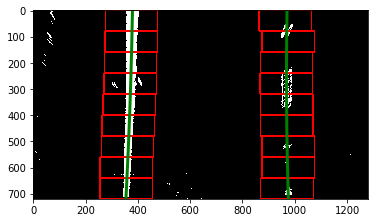

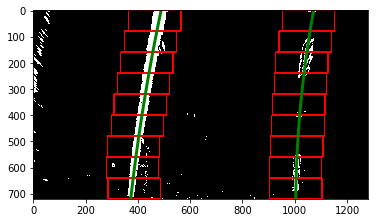

'DONE'

In [543]:
def test_get_lane_boxes(img_name):
    # Process the image
    binary_img = lanes_starting_image(img_name=img_name)
    histogram_img = histogram(binary_img)
    img = binary_to_rgb(binary_img)

    # Get the lane base
    left_base, right_base = get_lane_bases(histogram_img)
    
    # Calculate boxes and indices
    left_boxes, left_indices = get_lane_boxes(binary_img, left_base, 9, 50, 100)
    right_boxes, right_indices = get_lane_boxes(binary_img, right_base, 9, 50, 100)
    boxes = left_boxes + right_boxes
    for box in boxes:
        points = np.int32([
            (box['xlow'], box['ylow']),
            (box['xlow'], box['yhigh']),
            (box['xhigh'], box['yhigh']),
            (box['xhigh'], box['ylow'])
        ])
        cv2.polylines(img, [points], True, (255, 0, 0), thickness=3)
        
    # Fit line
    left_line = fit_line(binary_img, left_indices)
    right_line = fit_line(binary_img, right_indices)
    
    plot_line = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    left_plot_line = left_line[0]*plot_line**2 + left_line[1]*plot_line + left_line[2]
    right_plot_line = right_line[0]*plot_line**2 + right_line[1]*plot_line + right_line[2]
    
    fig = plt.figure()
    plt.imshow(img, cmap='gray')
    plt.plot(left_plot_line, plot_line, color='green', linewidth=3.0)
    plt.plot(right_plot_line, plot_line, color='green', linewidth=3.0)
    plt.show()
    plt.close(fig)
        
    return img
    
test_get_lane_boxes('straight_lines1.jpg')
test_get_lane_boxes('test3.jpg')
"DONE"

#### Observation

Lanes look good for the straight and curved examples.

### 5.d Find lane boxes in the next frame

Now that we have done the heavylifting for a frame, the next frame calculation can be more focused.

In [549]:
# Binary image is the lane image processed using the pipleline to yield
# a binary image
# Line fit is the lane that was detected in the previous iterations
# Margin is +-width for search
def get_lane_indices_from_existing_line(binary_img, line_fit, margin):
    # Get non zero pixel co-ordinates
    nonzerox, nonzeroy = get_non_zero_pixels(binary_img)
    
    # Find good indices
    lane_y = line_fit[0]*(nonzeroy**2) + line_fit[1]*nonzeroy + line_fit[2]
    lane_indices = (nonzerox > (lane_y - margin)) & (nonzerox < (lane_y + margin))
    
    # Find pixel positions
    final_lane_x = nonzerox[lane_indices]
    final_lane_y = nonzeroy[lane_indices]
    
    return np.polyfit(final_lane_y, final_lane_x, 2)

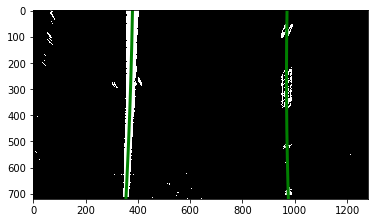

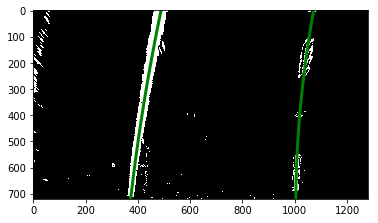

In [550]:
def test_get_lane_indices_from_existing_line(img_name):
    ### === BOILERPLATE === ###
    # Process the image
    binary_img = lanes_starting_image(img_name=img_name)
    histogram_img = histogram(binary_img)
    img = binary_to_rgb(binary_img)
    
    # Get the lane base
    left_base, right_base = get_lane_bases(histogram_img)
    
    # Get lane indices
    _, left_indices = get_lane_boxes(binary_img, left_base, 9, 50, 100)
    _, right_indices = get_lane_boxes(binary_img, right_base, 9, 50, 100)
    
    # Fit the lines for the very first frame
    left_line = fit_line(binary_img, left_indices)
    right_line = fit_line(binary_img, right_indices)
    
    ### === REAL TEST === ###
    # We'll use the found left and right line and calculate the lanes
    # for the same image again
    calc_left_line = get_lane_indices_from_existing_line(binary_img, left_line, 100)
    calc_right_line = get_lane_indices_from_existing_line(binary_img, right_line, 100)
    
    # Plotting
    plot_line = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    left_plot_line = calc_left_line[0]*plot_line**2 + calc_left_line[1]*plot_line + calc_left_line[2]
    right_plot_line = calc_right_line[0]*plot_line**2 + calc_right_line[1]*plot_line + calc_right_line[2]
    
    fig = plt.figure()
    plt.imshow(img, cmap='gray')
    plt.plot(left_plot_line, plot_line, color='green', linewidth=3.0)
    plt.plot(right_plot_line, plot_line, color='green', linewidth=3.0)
    plt.show()
    plt.close(fig)
    
test_get_lane_indices_from_existing_line('straight_lines1.jpg')
test_get_lane_indices_from_existing_line('test3.jpg')

#### Observation

Looks good. We had restricted our search are to the previous line's +-margin, and fitted this new line around all the pixels in that window.

## 6. Measuring curvature

In [552]:
def measure_curvature(line_fit, y_eval, ym_per_pix=1):
    curverad = ((1 + (2*line_fit[0]*y_eval*ym_per_pix + line_fit[1])**2)**1.5) / np.absolute(2*line_fit[0])
    
    return curverad

In [556]:
def test_measure_curvature(img_name):
    # Process the image
    binary_img = lanes_starting_image(img_name=img_name)
    histogram_img = histogram(binary_img)
    img = binary_to_rgb(binary_img)
    
    # Get the lane base
    left_base, right_base = get_lane_bases(histogram_img)
    
    # Get lane indices
    _, left_indices = get_lane_boxes(binary_img, left_base, 9, 50, 100)
    _, right_indices = get_lane_boxes(binary_img, right_base, 9, 50, 100)
    
    # Fit the lines for the very first frame
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = binary_img.shape[0]

    left_line = fit_line(binary_img, left_indices, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix)
    right_line = fit_line(binary_img, right_indices)
    
    print(measure_curvature(left_line, y_eval, ym_per_pix))
    print(measure_curvature(right_line, y_eval, ym_per_pix))
    
test_measure_curvature('straight_lines1.jpg')
test_measure_curvature('test3.jpg')

6863.28658073
15101.51518
2493.10759583
4430.60522487


#### Observation

As expected, the straight lines report a higher radius of curvature. Of course, the calculations are a bit sensitive to each lane's "angle", so we can see differences in the RoC of the left and the right lane.